In [1]:
%run 'Data Cleaning.ipynb'

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
object_columns = df_clean_v1.select_dtypes(include=['object']).columns

onehot_enc = OneHotEncoder(drop = 'first')

onehot_enc.fit_transform(df_clean_v1[object_columns])

<21879x28 sparse matrix of type '<class 'numpy.float64'>'
	with 130623 stored elements in Compressed Sparse Row format>

In [5]:
df_clean_v1

,respondent_id,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,...,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,seasonal_vaccine
0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0
1,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,...,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0
2,3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,1
3,4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0
4,5,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,Male,"<= $75,000, Above Poverty",Married,Own,Employed,atmpeygn,"MSA, Principle City",2.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26700,26701,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,Female,"> $75,000",Not Married,Rent,Not in Labor Force,fpwskwrf,"MSA, Principle City",3.0,0.0,0
26701,26702,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,0
26702,26703,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,0
26704,26705,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,0


In [6]:
object_cols = df_clean_v1.select_dtypes(include=['object'])

# Apply one-hot encoding
one_hot_encoded_cols = pd.get_dummies(object_cols).astype(int)

# Merge with the original DataFrame
df = df_clean_v1.drop(object_cols.columns, axis=1)
df = pd.concat([df, one_hot_encoded_cols], axis=1)

# Logistic Regression 

In [7]:
# Wesley original:
# df.drop(columns=['respondent_id'])
df.drop(columns=["respondent_id"], axis=1, inplace=True)
data = df.drop(columns=df.select_dtypes(include=['object']).columns)

X = data.drop(columns=['seasonal_vaccine'])
y = data['seasonal_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

for col in float_columns:
    median = X_train[col].median()
    X_train[col].fillna(median,inplace=True)
    
for col in float_columns:
    median = X_test[col].median()
    X_test[col].fillna(median,inplace=True)

Hyperparameter tuning on $C$, the inverse regularization strength.

In [8]:
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
cv_scores = []
cv_scores_std = []

for c in C_list:
    logreg = LogisticRegression(C = c, max_iter=1000) #Using the default lbfgs solver
    cv_loop_results = cross_validate(
                X = X_train,
                y = y_train,
                estimator = logreg, 
                cv = 7)
    cv_scores.append(np.mean(cv_loop_results["test_score"]))
    cv_scores_std.append(np.std(cv_loop_results["test_score"]))

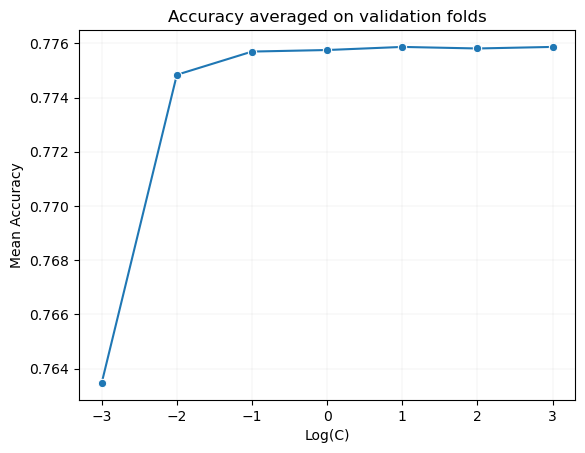

In [9]:
fig, ax = plt.subplots()
sns.lineplot(x=np.log10(C_list), y=cv_scores, marker="o", ax=ax)
ax.set_xlabel("Log(C)")
ax.set_ylabel("Mean Accuracy")
ax.set_title("Accuracy averaged on validation folds")
plt.grid(linewidth=0.1)
plt.show()

Cross Validation Scores

In [10]:
cv_scores

[0.7634696064431371,
 0.774839549894328,
 0.7756961672473867,
 0.7757533786485407,
 0.7758676415148226,
 0.7758105215056835,
 0.7758676643628263]

In [11]:
cv_scores_std

[0.0053895797720975485,
 0.0059571097223304744,
 0.004697130738254792,
 0.004824381772704777,
 0.004839391962766399,
 0.004885766639478661,
 0.004931874972935821]

C = 1 is the best fit.

In [12]:
logreg_best = LogisticRegression(C=1, max_iter=1000)
logreg_best.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000)

In [13]:
logreg_best.score(X_test,y_test)

0.7822212065813529

Post tuning, this model predicts at 78% accuracy.

In [14]:
y_pred = logreg_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      2282
           1       0.78      0.76      0.77      2094

    accuracy                           0.78      4376
   macro avg       0.78      0.78      0.78      4376
weighted avg       0.78      0.78      0.78      4376



Looking at feature coefficients.

In [15]:
# Extracting the coefficients from the logistic regression model
coefficients = pd.DataFrame({"Feature": X_train.columns, "Coefficient": logreg_best.coef_[0]})

# Sorting the coefficients by their absolute values in descending order
coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()
sorted_coefficients = coefficients.sort_values(by="Absolute Coefficient", ascending=False)

sorted_coefficients.head(10)  # Displaying the top 10 features based on coefficients

,Feature,Coefficient,Absolute Coefficient
7,doctor_recc_seasonal,1.274987,1.274987
21,age_group_65+ Years,0.892130,0.892130
10,health_worker,0.864741,0.864741
17,age_group_18 - 34 Years,-0.610349,0.610349
12,opinion_seas_vacc_effective,0.597997,0.597997
13,opinion_seas_risk,0.553743,0.553743
11,health_insurance,0.453920,0.453920
18,age_group_35 - 44 Years,-0.326186,0.326186
6,behavioral_touch_face,0.230444,0.230444
26,race_Black,-0.220022,0.220022


The best feature from the model is the seasonal flu vaccine being recommended by doctor.

In [16]:
#Best feature based on coefficients
data["doctor_recc_seasonal"]

0        0.0
1        NaN
2        1.0
3        0.0
4        1.0
        ... 
26700    0.0
26701    0.0
26702    1.0
26704    0.0
26705    0.0
Name: doctor_recc_seasonal, Length: 21879, dtype: float64

ROC Curve, True Positive Rate and False Positive Rate

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

In [18]:
y_prob = logreg_best.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

In [19]:
thresholds[1::]

array([0.98495581, 0.97462462, 0.97407372, ..., 0.0104202 , 0.01002365,
       0.0043195 ])

In [20]:
thresh_df = pd.DataFrame({"threshold": thresholds,
                          "tpr":  tpr, "fpr": fpr}).iloc[1::, :]
thresh_df.head(10)

,threshold,tpr,fpr
1,0.984956,0.000478,0.000000
2,0.974625,0.013849,0.000000
3,0.974074,0.013849,0.000438
4,0.971295,0.022445,0.000438
5,0.970875,0.022445,0.000876
6,0.968545,0.028653,0.000876
7,0.968522,0.028653,0.001315
8,0.966514,0.033906,0.001315
9,0.966434,0.033906,0.001753
10,0.966032,0.034384,0.001753


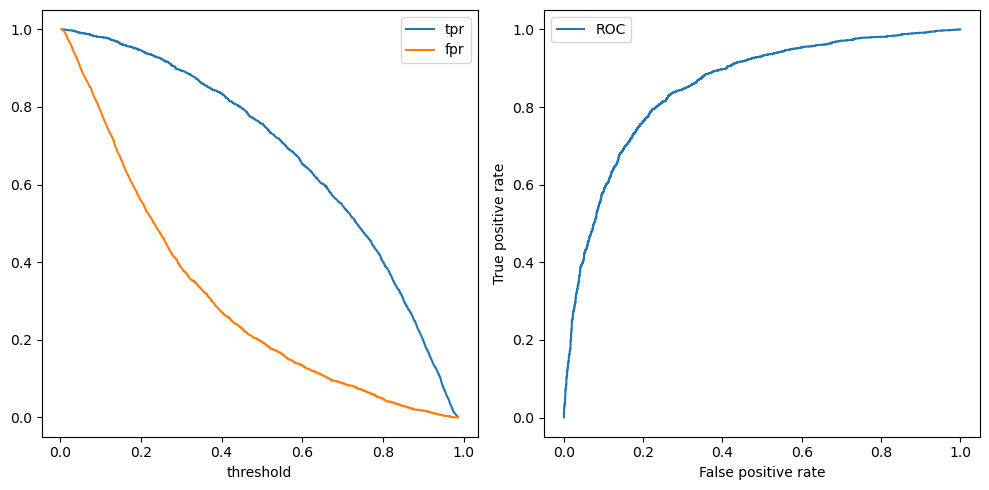

In [21]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
thresh_df.plot(x = "threshold", y = "tpr", ax = ax[0])
thresh_df.plot(x = "threshold", y = "fpr", ax = ax[0])
thresh_df.plot(x = "fpr", y = 'tpr', ax = ax[1], label = "ROC")
ax[1].set_ylabel("True positive rate")
ax[1].set_xlabel("False positive rate")
plt.tight_layout()

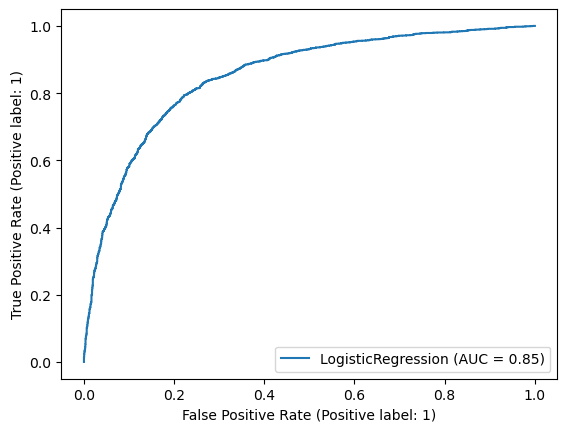

In [22]:
RocCurveDisplay.from_estimator(logreg_best, X_test, y_test);